Actuary Salary Prediction Model 
Author: Steve
Objective: Build an end-to-end machine learning pipeline to predict actuary salaries using demographic, education, and job-related features.

This project demonstrates:

Data cleaning & exploratory data analysis (EDA)
Feature engineering
Model training and comparison
Model evaluation
Model persistence

In [24]:
#The libraries used in cleaning,exploring, building and deploying the model
import warnings
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from glob import glob
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import joblib
warnings.simplefilter(action="ignore", category=FutureWarning)

In [31]:
#Function used in wrangling the data
def wrangle(filepath):
    df=pd.read_csv(filepath)
    #removing the salary column
    df.drop(columns=["salary"],inplace=True)
    #droping the leakages
    #df=df.drop(columns=["salary_low","salary_high"])
    return(df)

In [32]:
df=wrangle("C:/Users/musyo/Downloads/Datasets-20240315/actuary_salaries.csv")
print("df shape:",df.shape)
df.head()

df shape: (138, 6)


,industry,exams,experience,salary_low,salary_mid,salary_high
0,Casualty,1 Exam,1,48,56.5,65
1,Casualty,2 Exams,1,50,60.5,71
2,Casualty,3 Exams,1,54,65.5,77
3,Casualty,4 Exams,1,58,70.0,82
4,Casualty,1 Exam,3,54,63.0,72


In [33]:
#Data Overview
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   industry     138 non-null    object 
 1   exams        138 non-null    object 
 2   experience   138 non-null    int64  
 3   salary_low   138 non-null    int64  
 4   salary_mid   138 non-null    float64
 5   salary_high  138 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 6.6+ KB
None


In [34]:
#Summary Statistics
print("summary statistics:")
df.describe()

summary statistics:


,experience,salary_low,salary_mid,salary_high
count,138.000000,138.000000,138.000000,138.000000
mean,7.036232,79.427536,99.137681,118.847826
std,4.994025,25.688160,48.853601,75.337770
min,1.000000,11.000000,38.500000,6.000000
25%,3.000000,60.000000,66.500000,76.000000
50%,5.000000,74.000000,83.750000,98.000000
75%,10.000000,94.000000,114.500000,138.000000
max,20.000000,158.000000,302.500000,447.000000


In [50]:
print(
    f"unique values:{df.select_dtypes('object').nunique()}")

unique values:industry     4
exams       16
dtype: int64


##Exploratory Data Analysis (EDA)

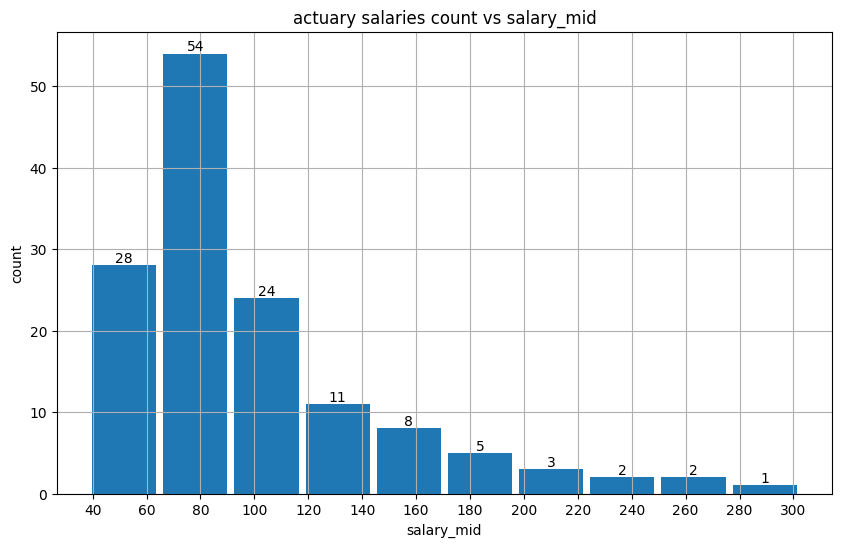

In [11]:
fig,ax=plt.subplots(figsize=(10,6))
plt.hist(df["salary_mid"],rwidth=0.9,bins=10)
for container in ax.containers:
    ax.bar_label(container,fmt="%.f")
plt.xlabel("salary_mid"),
plt.xticks(ticks=range(40, 320,20)),
plt.ylabel("count"),
plt.title("actuary salaries count vs salary_mid")
plt.grid(True);

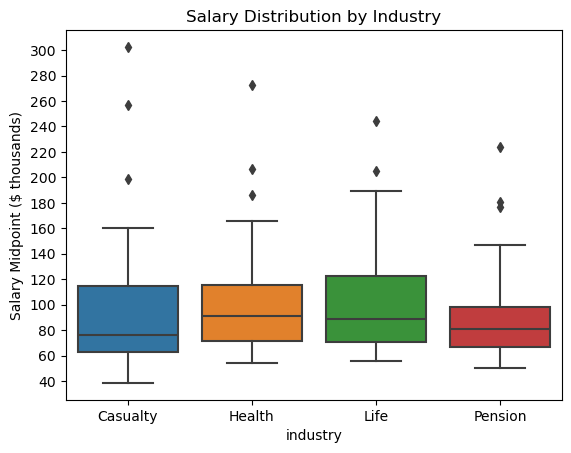

In [249]:
sns.boxplot(df,x="industry",y="salary_mid")
plt.title('Salary Distribution by Industry')
plt.ylabel('Salary Midpoint ($ thousands)')
plt.yticks(ticks=range(40,320,20));

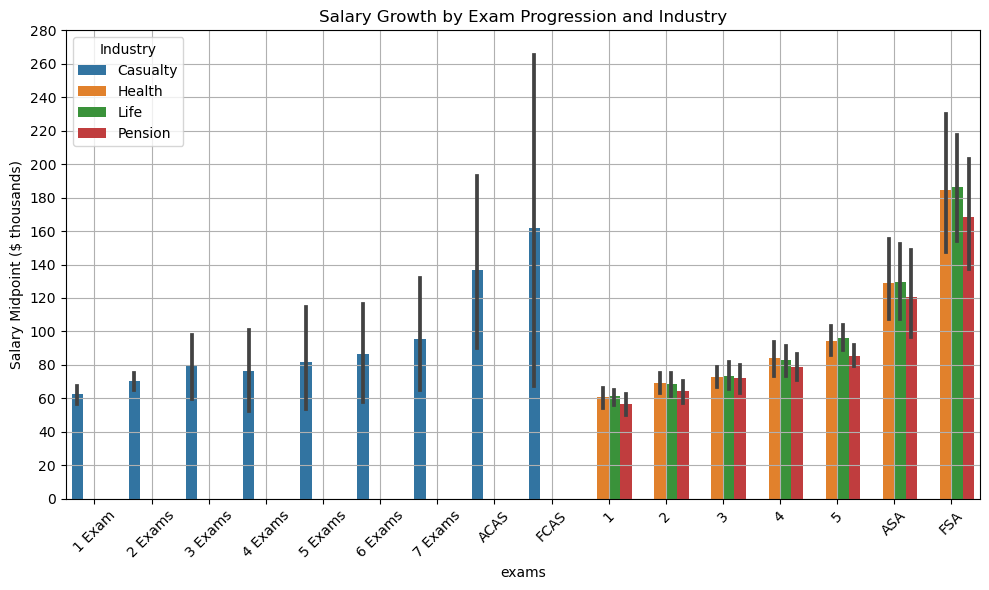

In [213]:
fig,ax=plt.subplots(figsize=(10,6))
sns.barplot(df,x="exams",y="salary_mid",hue="industry")
plt.xticks(rotation=45)
plt.yticks(ticks=range(0,300,20))
plt.title('Salary Growth by Exam Progression and Industry')
plt.ylabel('Salary Midpoint ($ thousands)')
plt.legend(title='Industry',loc="upper left")
plt.grid(True)
plt.tight_layout();

##Feature Engineering

In [35]:
X = df.drop(columns=['salary_mid'])
y = df['salary_mid']

categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [36]:
X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.2,random_state=42
)

In [38]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42)
}

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds)
    })

results_df = pd.DataFrame(results)
results_df

,Model,MAE,RMSE,R2
0,Linear Regression,7.612958e-15,1.329304e-14,1.000000
1,Ridge Regression,2.998656e-04,4.282206e-04,1.000000
2,Lasso Regression,1.219747e-03,1.506211e-03,1.000000
3,Random Forest,4.209821e+00,6.466857e+00,0.986732


 ##Best Model Selection & Saving

In [39]:
best_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

best_model.fit(X_train, y_train)

#joblib.dump(best_model, "../models/best_model.pkl")


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##Model Evaluation

In [41]:
final_preds = best_model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, final_preds))
print("RMSE:",np.sqrt(mean_squared_error(y_test, preds)))
print("R²:", r2_score(y_test, final_preds))


MAE: 7.61295788314393e-15
RMSE: 6.466856986644615
R²: 1.0


In [47]:
#Communicating the Results
def make_prediction(industry ,exams,experience,salary_low,salary_high):
    data={
        "industry":industry,
        "exams":exams,
        "experience":experience,
        "salary_low":salary_low,
        "salary_high":salary_high
        }
    df=pd.DataFrame(data,index=[0])
    prediction =best_model.predict(df).round(2)[0]
    return f"Predicted salary_mid: {prediction}"

In [48]:
make_prediction("Pension","4" , 17,26,86)

'Predicted salary_mid: 56.0'

In [49]:
interact(
      make_prediction,
    industry=Dropdown(options=sorted(X_train["industry"].unique())),
    exams=Dropdown(options=sorted(X_train["exams"].unique())),
    
    experience=IntSlider(
        min=X_train["experience"].min(),
        max=X_train["experience"].max(),
        value=X_train["experience"].mean(),
    ),
     salary_low=IntSlider(
        min=X_train["salary_low"].min(),
        max=X_train["salary_low"].max(),
        value=X_train["salary_low"].mean(),
    ),
     salary_high=IntSlider(
        min=X_train["salary_high"].min(),
        max=X_train["salary_high"].max(),
        value=X_train["salary_high"].mean(),
    ),
);

interactive(children=(Dropdown(description='industry', options=('Casualty', 'Health', 'Life', 'Pension'), valu…